In [651]:
import geopandas as gpd
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
map_gpd = gpd.read_file(map_url)
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
gdf.head()

,geometry,pop10,nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


In [36]:
filepath = 'C:\\Users\\renan\\Desktop\\full_count_2010\\std_2010_fullcount.csv'
census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
dissim_index = Dissim(df, 'nhblk10', 'pop10')
dissim_index.statistic

0.31565682496226544

In [196]:
dissim_index.core_data.head()

,group_pop_var,total_pop_var,other_group_pop
5727,677,6242,5565
5729,844,10258,9414
5731,405,6342,5937
5733,346,2594,2248
5735,429,3586,3157


In [61]:
"""
Atkinson Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Atkinson']


def _atkinson(data, group_pop_var, total_pop_var, b = 0.5):
    """
    Calculation of Entropy index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    b             : float
                    The shape parameter, between 0 and 1, that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

    Attributes
    ----------

    statistic : float
                Atkinson Index
    
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if (not isinstance(b, float)):
        raise ValueError('The parameter b must be a float.')
        
    if ((b < 0) or (b > 1)):
        raise ValueError('The parameter b must be between 0 and 1.')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(ti = data.total_pop_var,
                       pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    A = 1 - (P / (1-P)) * abs((((1 - data.pi) ** (1-b) * data.pi ** b * data.ti) / (P * T)).sum()) ** (1 / (1 - b))
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return A, core_data


class Atkinson:
    """
    Classic Atkinson Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    b             : float
                    The shape parameter, between 0 and 1, that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

    Attributes
    ----------

    statistic : float
                Atkison Index
    
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.
        
    Examples
    --------
    In this example, we will calculate the Atkinson Index (A) with the shape parameter (b) equals to 0.5 for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> atkinson_index = Atkinson(df, 'nhblk10', 'pop10', b = 0.5)
    >>> atkinson_index.statistic
    0.16722406110274002
       
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var, b = 0.5):

        self.statistic = _atkinson(data, group_pop_var, total_pop_var, b)[0]
        self.core_data = _atkinson(data, group_pop_var, total_pop_var, b)[1]
        self._function = _atkinson



In [237]:
"""
Gini Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Gini_Seg']


def _gini_seg(data, group_pop_var, total_pop_var):
    """
    Calculation of Gini Segregation index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Gini Segregation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(ti = data.total_pop_var,
                       pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    num = (np.matmul(np.array(data.ti)[np.newaxis].T, np.array(data.ti)[np.newaxis]) * abs(np.array(data.pi)[np.newaxis].T - np.array(data.pi)[np.newaxis])).sum()
    den = (2 * T**2 * P * (1-P))
    G = num / den
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return G, core_data


class Gini_Seg:
    """
    Classic Gini Segregation Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Gini Segregation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Examples
    --------
    In this example, we will calculate the Gini Segregation Index (G) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> gini_seg_index = Gini_Seg(df, 'nhblk10', 'pop10')
    >>> gini_seg_index.statistic
    0.44620350030600087
       
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _gini_seg(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _gini_seg



In [242]:
df = gdf
delta_index = Dissim(df, 'nhblk10', 'pop10')
delta_index.core_data

,group_pop_var,total_pop_var
0,677,6242
1,844,10258
2,405,6342
3,346,2594
4,429,3586
5,707,4782
6,212,6080
7,47,3480
8,921,7610
9,138,2266


# Inference Wrappers

In [243]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd

__all__ = ['Infer_Segregation']

def _infer_segregation(seg_class, iterations = 500, null_approach = "systematic", **kwargs):
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class: a PySAL segregation object
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hyphotesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "eveness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence os systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  One-Tailed p-value
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures. Therefore, it is better to rely on the est_sim attribute.
    
    '''
    
    point_estimation = seg_class.statistic
    data             = seg_class.core_data
    
    if (null_approach == "systematic"):
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    
    
    if (null_approach == "eveness"):
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
            
        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
        
        
    if (null_approach == "permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data = data.assign(geometry = data['geometry'][list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            df_aux = data
            Estimates_Stars[i] = seg_class._function(df_aux, 'group_pop_var', 'total_pop_var', **kwargs)[0]
            
        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations

    
    
    if (null_approach == "systematic_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    
    
    
    if (null_approach == "even_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
            
        # One-Tailed p-value
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    
    
        
    return p_value, Estimates_Stars



class Infer_Segregation:
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class: a PySAL segregation object
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hyphotesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "eveness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence os systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  One-Tailed p-value
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures. Therefore, it is better to rely on the est_sim attribute.
    
    '''

    def __init__(self, seg_class, iterations = 500, null_approach = "systematic", **kwargs):

        self.p_value = _infer_segregation(seg_class, iterations, null_approach, **kwargs)[0]
        self.est_sim = _infer_segregation(seg_class, iterations, null_approach, **kwargs)[1]

In [244]:
data = delta_index.core_data
data.head()

,group_pop_var,total_pop_var
0,677,6242
1,844,10258
2,405,6342
3,346,2594
4,429,3586


In [245]:
(str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>')

True

In [246]:
(str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>')

False

In [247]:
delta_index.core_data

,group_pop_var,total_pop_var
0,677,6242
1,844,10258
2,405,6342
3,346,2594
4,429,3586
5,707,4782
6,212,6080
7,47,3480
8,921,7610
9,138,2266


In [248]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(Infer_Segregation(delta_index, null_approach = "systematic_permutation").est_sim, 
                 hist=True, 
                 #kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
plt.axvline([delta_index.statistic], color = 'red')
plt.title('dis')
plt.show()

TypeError: data is not a GeoDataFrame, therefore, this null approach does not apply.

In [249]:
delta_index.core_data

,group_pop_var,total_pop_var
0,677,6242
1,844,10258
2,405,6342
3,346,2594
4,429,3586
5,707,4782
6,212,6080
7,47,3480
8,921,7610
9,138,2266


In [250]:
type(delta_index)

__main__.Dissim

In [251]:
str(type(delta_index))

"<class '__main__.Dissim'>"

In [252]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

__all__ = ['Infer_Segregation']

def _infer_segregation(seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''
    
    if (type(two_tailed) is not bool):
        raise TypeError('two_tailed is not a boolean object')
    
    point_estimation = seg_class.statistic
    data             = seg_class.core_data
    
    if (null_approach == "systematic"):
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
                
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
    
    
    if (null_approach == "evenness"):
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
            
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
        
        
    if (null_approach == "permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data = data.assign(geometry = data['geometry'][list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            df_aux = data
            Estimates_Stars[i] = seg_class._function(df_aux, 'group_pop_var', 'total_pop_var', **kwargs)[0]

    
    if (null_approach == "systematic_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]  
    
    
    if (null_approach == "even_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

    
    if not two_tailed:
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    else:
        p_value = (sum(Estimates_Stars > abs(point_estimation)) + sum(Estimates_Stars < -abs(point_estimation))) / iterations
        
    return p_value, Estimates_Stars, point_estimation



class Infer_Segregation:
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''

    def __init__(self, seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
        
        aux = _infer_segregation(seg_class, iterations, null_approach, two_tailed, **kwargs)

        self.p_value   = aux[0]
        self.est_sim   = aux[1]
        self.statistic = aux[2]
        
    def plot(self):
        """
        Plot the Infer_Segregation class
        """
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib` and `seaborn`')
        #graph = plt.scatter(self.grid, self.curve, s = 0.1)
        #return graph
    
        sns.distplot(self.est_sim, 
                     hist = True, 
                     color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 2})
        plt.axvline(self.statistic, color = 'red')
        plt.title(str(type(self)))
        return plt.show()

In [253]:
res = Infer_Segregation(delta_index)

KeyError: 'geometry'

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


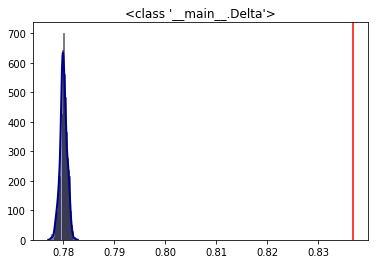

In [254]:
res.plot()

In [255]:
str(type(delta_index))

"<class '__main__.Dissim'>"

In [225]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

__all__ = ['Infer_Segregation']

def _infer_segregation(seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''
    
    if (type(two_tailed) is not bool):
        raise TypeError('two_tailed is not a boolean object')
    
    point_estimation = seg_class.statistic
    data             = seg_class.core_data
    
    if (null_approach == "systematic"):
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
                
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
    
    
    if (null_approach == "evenness"):
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
            
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
        
        
    if (null_approach == "permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data = data.assign(geometry = data['geometry'][list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            df_aux = data
            Estimates_Stars[i] = seg_class._function(df_aux, 'group_pop_var', 'total_pop_var', **kwargs)[0]

    
    if (null_approach == "systematic_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]  
    
    
    if (null_approach == "even_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

    
    if not two_tailed:
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    else:
        p_value = (sum(Estimates_Stars > abs(point_estimation)) + sum(Estimates_Stars < -abs(point_estimation))) / iterations
        
    return p_value, Estimates_Stars, point_estimation, str(type(seg_class))



class Infer_Segregation:
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''

    def __init__(self, seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
        
        aux = _infer_segregation(seg_class, iterations, null_approach, two_tailed, **kwargs)

        self.p_value   = aux[0]
        self.est_sim   = aux[1]
        self.statistic = aux[2]
        self.seg_name  = aux[3]
        
    def plot(self):
        """
        Plot the Infer_Segregation class
        """
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib` and `seaborn`')
        #graph = plt.scatter(self.grid, self.curve, s = 0.1)
        #return graph
    
        sns.distplot(self.est_sim, 
                     hist = True, 
                     color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 2})
        plt.axvline(self.statistic, color = 'red')
        plt.title(self.seg_name)
        return plt.show()

In [232]:
str(type(delta_index))

"<class '__main__.Delta'>"

In [233]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

__all__ = ['Infer_Segregation']

def _infer_segregation(seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''
    
    if (type(two_tailed) is not bool):
        raise TypeError('two_tailed is not a boolean object')
    
    point_estimation = seg_class.statistic
    data             = seg_class.core_data
    
    _class_name       = str(type(seg_class))
    
    if (null_approach == "systematic"):
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
                
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
    
    
    if (null_approach == "evenness"):
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
            
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
        
        
    if (null_approach == "permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data = data.assign(geometry = data['geometry'][list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            df_aux = data
            Estimates_Stars[i] = seg_class._function(df_aux, 'group_pop_var', 'total_pop_var', **kwargs)[0]

    
    if (null_approach == "systematic_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]  
    
    
    if (null_approach == "even_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

    
    if not two_tailed:
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    else:
        p_value = (sum(Estimates_Stars > abs(point_estimation)) + sum(Estimates_Stars < -abs(point_estimation))) / iterations
        
    return p_value, Estimates_Stars, point_estimation, _class_name



class Infer_Segregation:
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''

    def __init__(self, seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
        
        aux = _infer_segregation(seg_class, iterations, null_approach, two_tailed, **kwargs)

        self.p_value      = aux[0]
        self.est_sim      = aux[1]
        self.statistic    = aux[2]
        self._class_name  = aux[3]
        
    def plot(self):
        """
        Plot the Infer_Segregation class
        """
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib` and `seaborn`')
        #graph = plt.scatter(self.grid, self.curve, s = 0.1)
        #return graph
    
        sns.distplot(self.est_sim, 
                     hist = True, 
                     color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 2})
        plt.axvline(self.statistic, color = 'red')
        plt.title(self._class_name)
        return plt.show()

In [256]:
df.head()

,geometry,pop10,nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


In [270]:
index = Dissim(df, 'nhblk10', 'pop10')

In [271]:
data             = index.core_data

In [274]:
res = Infer_Segregation(index)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


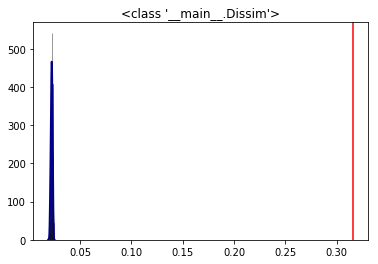

In [275]:
res.plot()

In [269]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

__all__ = ['Infer_Segregation']

def _infer_segregation(seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''
    
    if (type(two_tailed) is not bool):
        raise TypeError('two_tailed is not a boolean object')
    
    point_estimation = seg_class.statistic
    data             = seg_class.core_data
    
    _class_name       = str(type(seg_class))
    
    if (null_approach == "systematic"):
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
                
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
    
    
    if (null_approach == "evenness"):
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            
            if (str(type(data)) == '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
                df_aux = gpd.GeoDataFrame(df_aux)
                df_aux['geometry'] = data['geometry']
            
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]
        
        
    if (null_approach == "permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data = data.assign(geometry = data['geometry'][list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            df_aux = data
            Estimates_Stars[i] = seg_class._function(df_aux, 'group_pop_var', 'total_pop_var', **kwargs)[0]

    
    if (null_approach == "systematic_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
    
        data['other_group_pop'] = data['total_pop_var'] - data['group_pop_var']
        p_j = data['total_pop_var'] / data['total_pop_var'].sum()

        # Group 0: minority group
        p0_i = p_j
        n0 = data['group_pop_var'].sum()
        sim0 = np.random.multinomial(n0, p0_i, size = iterations)

        # Group 1: complement group
        p1_i = p_j
        n1 = data['other_group_pop'].sum()
        sim1 = np.random.multinomial(n1, p1_i, size = iterations)

        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]  
    
    
    if (null_approach == "even_permutation"):
        
        if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
            raise TypeError('data is not a GeoDataFrame, therefore, this null approach does not apply.')
        
        p_null = data['group_pop_var'].sum() / data['total_pop_var'].sum()
        
        Estimates_Stars = np.empty(iterations)
        
        for i in np.array(range(iterations)):
            sim = np.random.binomial(n = np.array([data['total_pop_var'].tolist()]), 
                                     p = p_null)
            data_aux = {'simul_group': sim[0], 'simul_tot': data['total_pop_var'].tolist()}
            df_aux = pd.DataFrame.from_dict(data_aux)
            df_aux = gpd.GeoDataFrame(df_aux)
            df_aux['geometry'] = data['geometry']
            df_aux = df_aux.assign(geometry = df_aux['geometry'][list(np.random.choice(df_aux.shape[0], df_aux.shape[0], replace = False))].reset_index()['geometry'])
            Estimates_Stars[i] = seg_class._function(df_aux, 'simul_group', 'simul_tot', **kwargs)[0]

    
    if not two_tailed:
        p_value = sum(Estimates_Stars > point_estimation) / iterations
    else:
        p_value = (sum(Estimates_Stars > abs(point_estimation)) + sum(Estimates_Stars < -abs(point_estimation))) / iterations
        
    return p_value, Estimates_Stars, point_estimation, _class_name



class Infer_Segregation:
    '''
    Perform inference for a single segregation measure

    Parameters
    ----------

    seg_class     : a PySAL segregation object
    
    iterations    : number of iterations under null hyphothesis
    
    null_approach : argument that specifies which type of null hypothesis the inference will iterate.
    
        "systematic"             : assumes that every group has the same probability with restricted conditional probabilities p_0_j = p_1_j = p_j = n_j/n (multinomial distribution).
        "evenness"                : assumes that each spatial unit has the same global probability of drawing elements from the minority group of the fixed total unit population (binomial distribution).
        
        "permutation"            : randomly allocates the units over space keeping the original values.
        
        "systematic_permutation" : assumes absence of systematic segregation and randomly allocates the units over space.
        "even_permutation"       : assumes the same global probability of drawning elements from the minority group in each spatial unit and randomly allocates the units over space.
    
    two_tailed    : boolean
                    If True, p_value is two-tailed. Otherwise, it is right one-tailed.
    
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same input that the seg_class was built.
    
    Attributes
    ----------

    p_value     : float
                  Pseudo One or Two-Tailed p-value estimated from the simulations
    
    est_sim     : numpy array
                  Estimates of the segregation measure under the null hypothesis
                  
    statistic   : float
                  The point estimation of the segregation measure that is under test
                
    Notes
    -----
    The one-tailed p_value attribute might not be appropriate for some measures, as the two-tailed. Therefore, it is better to rely on the est_sim attribute.
    
    '''

    def __init__(self, seg_class, iterations = 500, null_approach = "systematic", two_tailed = True, **kwargs):
        
        aux = _infer_segregation(seg_class, iterations, null_approach, two_tailed, **kwargs)

        self.p_value      = aux[0]
        self.est_sim      = aux[1]
        self.statistic    = aux[2]
        self._class_name  = aux[3]
        
    def plot(self):
        """
        Plot the Infer_Segregation class
        """
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib` and `seaborn`')
        #graph = plt.scatter(self.grid, self.curve, s = 0.1)
        #return graph
    
        sns.distplot(self.est_sim, 
                     hist = True, 
                     color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 2})
        plt.axvline(self.statistic, color = 'red')
        plt.title(self._class_name)
        return plt.show()

In [276]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

__all__ = ['Compare_Segregation']

def _compare_segregation(seg_class_1, seg_class_2, iterations = 500, null_approach = "random_data", **kwargs):
    '''
    Perform inference comparison for a two segregation measures

    Parameters
    ----------

    seg_class_1: a PySAL segregation object to be compared to seg_class_2
    
    seg_class_2: a PySAL segregation object to be compared to seg_class_1
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hypothesis the inference will iterate.
    
        "random_data"            : random label the data in each iteration
        
        "random_spatial"         : random label the spatial unit context (geometries) in each iteration
        
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same as both seg_class_1 and seg_class_2  was built.
    
    Attributes
    ----------

    p_value        : float
                     Two-Tailed p-value
    
    est_sim        : numpy array
                     Estimates of the segregation measure differences under the null hypothesis
                  
    est_point_diff : float
                     Point estimation of the difference between the segregation measures
                
    Notes
    -----
    This function performs inference to compare two segregation measures. This can be either two measures of the same locations in two different points in time or it can be two different locations at the same point in time.
    
    The null hypothesis is H0: Segregation_1 - Segregation_2 = 0 and, therefore, the est_sim attribute must be compared to the zero value.
    
    Based on Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. "Interregional inequality dynamics in Mexico." Spatial Economic Analysis 5.3 (2010): 277-298.

    '''
    
    if(type(seg_class_1) != type(seg_class_2)):
        raise TypeError('seg_class_1 and seg_class_2 must be the same type/class.')
    
    data_1 = seg_class_1.core_data
    data_2 = seg_class_2.core_data
    
    point_estimation = seg_class_1.statistic - seg_class_2.statistic
    
    _class_name = str(type(seg_class_1))
    
    # This step is just to make sure the each frequecy column is from the same type in order to stack them
    data_1['group_pop_var'] = round(data_1['group_pop_var']).astype(int)
    data_1['total_pop_var'] = round(data_1['total_pop_var']).astype(int)
    
    data_2['group_pop_var'] = round(data_2['group_pop_var']).astype(int)
    data_2['total_pop_var'] = round(data_2['total_pop_var']).astype(int)
    
    data_1['grouping_variable'] = 'Group_1'
    data_2['grouping_variable'] = 'Group_2'
    
    stacked_data = pd.concat([data_1, data_2], ignore_index=True)
    
    est_sim = np.empty(iterations)
    
    if (null_approach == "random_data"):
        
        for i in np.array(range(iterations)):
            
            aux_rand = list(np.random.choice(stacked_data.shape[0], stacked_data.shape[0], replace = False))

            stacked_data['rand_group_pop'] = stacked_data.group_pop_var[aux_rand].reset_index()['group_pop_var']
            stacked_data['rand_total_pop'] = stacked_data.total_pop_var[aux_rand].reset_index()['total_pop_var']
            
            # Dropping variable to avoid confusion in the calculate_segregation function 
            # Building auxiliar data to avoid affecting the next iteration
            stacked_data_aux = stacked_data.drop(['group_pop_var', 'total_pop_var'], axis = 1)
            
            stacked_data_1 = stacked_data_aux.loc[stacked_data_aux['grouping_variable'] == 'Group_1']
            stacked_data_2 = stacked_data_aux.loc[stacked_data_aux['grouping_variable'] == 'Group_2']

            simulations_1 = seg_class_1._function(stacked_data_1, 'rand_group_pop', 'rand_total_pop', **kwargs)[0]
            simulations_2 = seg_class_2._function(stacked_data_2, 'rand_group_pop', 'rand_total_pop', **kwargs)[0]
            
            est_sim[i] = simulations_1 - simulations_2
    
    
    if (null_approach == "random_spatial"):
        
        for i in np.array(range(iterations)):
            
            aux_rand = list(np.random.choice(stacked_data.shape[0], stacked_data.shape[0], replace = False))

            stacked_data['rand_grouping'] = stacked_data.grouping_variable[aux_rand].reset_index()['grouping_variable']
            
            stacked_data_1 = stacked_data.loc[stacked_data['rand_grouping'] == 'Group_1']
            stacked_data_2 = stacked_data.loc[stacked_data['rand_grouping'] == 'Group_2']

            simulations_1 = seg_class_1._function(stacked_data_1, 'group_pop_var', 'total_pop_var', **kwargs)[0]
            simulations_2 = seg_class_2._function(stacked_data_2, 'group_pop_var', 'total_pop_var', **kwargs)[0]
            
            est_sim[i] = simulations_1 - simulations_2

            
    # Two-Tailed p-value
    p_value = (sum(est_sim > abs(point_estimation)) + sum(est_sim < -abs(point_estimation))) / iterations
        
    return p_value, est_sim, point_estimation, _class_name



class Compare_Segregation:
    '''
    Perform inference comparison for a two segregation measures

    Parameters
    ----------

    seg_class_1: a PySAL segregation object to be compared to seg_class_2
    
    seg_class_2: a PySAL segregation object to be compared to seg_class_1
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hypothesis the inference will iterate.
    
        "random_data"            : random label the data in each iteration
        
        "random_spatial"         : random label the spatial unit context (geometries) in each iteration
        
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same as both seg_class_1 and seg_class_2  was built.
    
    Attributes
    ----------

    p_value        : float
                     Two-Tailed p-value
    
    est_sim        : numpy array
                     Estimates of the segregation measure differences under the null hypothesis
                  
    est_point_diff : float
                     Point estimation of the difference between the segregation measures
                
    Notes
    -----
    This function performs inference to compare two segregation measures. This can be either two measures of the same locations in two different points in time or it can be two different locations at the same point in time.
    
    The null hypothesis is H0: Segregation_1 - Segregation_2 = 0 and, therefore, the est_sim attribute must be compared to the zero value.
    
    Based on Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. "Interregional inequality dynamics in Mexico." Spatial Economic Analysis 5.3 (2010): 277-298.

    '''

    def __init__(self, seg_class_1, seg_class_2, iterations = 500, null_approach = "random_data", **kwargs):
        
        aux = _compare_segregation(seg_class_1, seg_class_2, iterations, null_approach, **kwargs)

        self.p_value        = aux[0]
        self.est_sim        = aux[1]
        self.est_point_diff = aux[2]
        self._class_name    = aux[3]
        
    def plot(self):
        """
        Plot the Compare_Segregation class
        """
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib` and `seaborn`')
    
        sns.distplot(self.est_sim, 
                     hist = True, 
                     color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 2})
        plt.axvline(self.est_point_diff, color = 'red')
        plt.title(self._class_name)
        return plt.show()

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


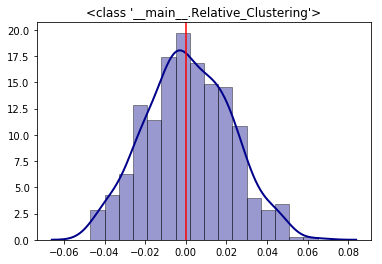

In [279]:
index1 = Relative_Clustering(df, 'nhblk10', 'pop10')
index2 = Relative_Clustering(df, 'nhblk10', 'pop10')
res = Compare_Segregation(index1, index2)
res.plot()

In [2]:
import numpy as np
x = np.array([4,7,6,9,10,11,23])
y = np.array([0.5, 0.7, 10, 20])

In [3]:
x

array([ 4,  7,  6,  9, 10, 11, 23])

# Cumulative Function Counterfactual

In [380]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('C:\\Users\\renan\\Desktop\\inequality\\inequality')

In [697]:
os.chdir('C:/Users/renan/Desktop/full_count_2010')
census_2010 = pd.read_csv('std_2010_fullcount.csv', encoding = "ISO-8859-1", sep = ",")

In [698]:
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
map_gpd = gpd.read_file(map_url)
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
gdf['share'] = np.where(gdf['pop10'] == 0, 0, gdf['nhblk10'] / gdf['nhblk10'].sum())
gdf['rel']   = np.where(gdf['pop10'] == 0, 0, gdf['nhblk10'] / gdf['pop10'])

In [699]:
df = census_2010.loc[census_2010.county == "San Bernardino County"][['trtid10', 'pop10','nhblk10']]

sb_map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06071.json'
sb_map_gpd = gpd.read_file(sb_map_url)
sb_map_gpd['INTGEOID10'] = pd.to_numeric(sb_map_gpd["GEOID10"])
sb_gdf_pre = sb_map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
sb_gdf = sb_gdf_pre[['geometry', 'pop10', 'nhblk10']]
sb_gdf['share'] = np.where(sb_gdf['pop10'] == 0, 0, sb_gdf['nhblk10'] / sb_gdf['nhblk10'].sum())
sb_gdf['rel']   = np.where(sb_gdf['pop10'] == 0, 0, sb_gdf['nhblk10'] / sb_gdf['pop10'])

In [700]:
len(gdf)

453

In [701]:
len(sb_gdf)

369

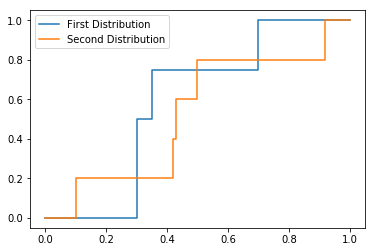

In [702]:
# Both appends are to force both distribution to have values in all space between 0 and 1
x_r = np.sort([0.3, 0.3, 0.35, 0.7])
y_r = np.arange(0, len(x_r)) / (len(x_r))

x_sb = np.sort([0.1, 0.5, 0.43, 0.92, 0.42])
y_sb = np.arange(0, len(x_sb)) / (len(x_sb))

x_r = np.append(np.append(0, x_r), 1)
y_r = np.append(np.append(0, y_r), 1)

x_sb = np.append(np.append(0, x_sb), 1)
y_sb = np.append(np.append(0, y_sb), 1)

plt.step(x_r,  y_r,  label='First Distribution')
plt.step(x_sb, y_sb, label='Second Distribution')
plt.legend()
plt.show()

In [703]:
y_r

array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

In [704]:
# Cdf is a cumulative function to the right, that's why this is just greater than: P(X <= x) = 1 - P(X > x)
y_r[np.where(x_r > 0.30)[0][0]]

0.5

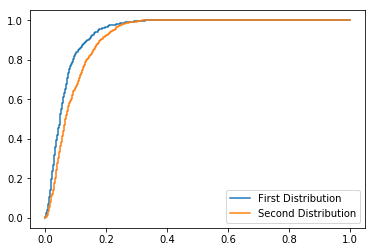

In [711]:
# Both appends are to force both distribution to have values in all space between 0 and 1
x_r = np.sort(gdf['rel'])
y_r = np.arange(0, len(x_r)) / (len(x_r))

x_sb = np.sort(sb_gdf['rel'])
y_sb = np.arange(0, len(x_sb)) / (len(x_sb))

x_r = np.append(np.append(0, x_r), 1)
y_r = np.append(np.append(0, y_r), 1)

x_sb = np.append(np.append(0, x_sb), 1)
y_sb = np.append(np.append(0, y_sb), 1)

plt.step(x_r,  y_r,  label='First Distribution')
plt.step(x_sb, y_sb, label='Second Distribution')
plt.legend()
plt.show()

In [390]:
# This is the direct cdf
y_sb[np.where(x_sb > 0.16)[0][0]]

0.8563685636856369

In [406]:
# This is the inverse cdf
x_sb[np.where(y_sb > 0.6)[0][0]]

0.08633582596872875

There is an -1 inside the index of the function to avoid frontier problems jumping directly to the 100% of the pseudo values. Continuous right frontier idiosyncrasy.

In [419]:
def inverse_cdf_r(pct):
    return x_r[np.where(y_r > pct)[0][0] - 1]

In [420]:
def inverse_cdf_sb(pct):
    return x_sb[np.where(y_sb > pct)[0][0] - 1]

In [421]:
# It has to be a minus 1 in the rank, in order to avoid 100% percentile in the max
gdf['cumulative_percentage'] = (gdf['rel'].rank()-1) / len(gdf)
gdf['pseudo_rel'] = gdf['cumulative_percentage'].apply(inverse_cdf_sb)
gdf['pseudo_nhblk10'] = gdf['pseudo_rel'] * gdf['pop10']

In [422]:
gdf.sort_values('rel')

,geometry,pop10,nhblk10,share,rel,cumulative_percentage,pseudo_rel,pseudo_nhblk10
291,"POLYGON ((-117.322444 33.954686, -117.321484 3...",9,0,0.000000,0.000000,0.000000,0.000000,0.000000
93,"POLYGON ((-116.181625 33.674717, -116.179482 3...",2804,4,0.000027,0.001427,0.002208,0.000000,0.000000
161,"POLYGON ((-116.026424 33.426331, -116.026548 3...",13694,28,0.000189,0.002045,0.004415,0.004930,67.509291
94,"POLYGON ((-116.181777 33.656562, -116.181735 3...",5708,12,0.000081,0.002102,0.006623,0.004972,28.377841
178,"POLYGON ((-116.199077 33.678204, -116.199071 3...",6397,16,0.000108,0.002501,0.008830,0.006277,40.156937
372,"POLYGON ((-116.233997 33.656642, -116.230964 3...",5880,15,0.000101,0.002551,0.011038,0.006294,37.010228
283,"POLYGON ((-117.542705 33.878094, -117.54374 33...",3288,9,0.000061,0.002737,0.013245,0.006294,20.695515
92,"POLYGON ((-116.164037 33.685805, -116.163713 3...",4821,14,0.000094,0.002904,0.015453,0.007264,35.019370
352,"POLYGON ((-117.506548 34.004929, -117.506075 3...",3543,13,0.000088,0.003669,0.017660,0.007313,25.910347
90,"POLYGON ((-116.199077 33.678204, -116.192609 3...",7522,28,0.000189,0.003722,0.019868,0.007878,59.257509


In [430]:
gdf['fair_coin'] = np.random.uniform(size = len(gdf))
gdf['test_nhblk10'] = np.where(gdf['fair_coin'] > 0.5, gdf['nhblk10'], gdf['pseudo_nhblk10'])

In [431]:
gdf.head()

,geometry,pop10,nhblk10,share,rel,cumulative_percentage,pseudo_rel,pseudo_nhblk10,fair_coin,test_nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677,0.004560,0.108459,0.841060,0.155515,970.722325,0.901471,677.000000
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844,0.005685,0.082277,0.763797,0.124866,1280.872126,0.464143,1280.872126
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405,0.002728,0.063860,0.633554,0.091492,580.245084,0.564470,405.000000
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346,0.002331,0.133385,0.887417,0.174935,453.782621,0.187686,453.782621
4,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429,0.002890,0.119632,0.865342,0.165296,592.753192,0.273543,592.753192


In [429]:
gdf.tail()

,geometry,pop10,nhblk10,share,rel,cumulative_percentage,pseudo_rel,pseudo_nhblk10,fair_coin
448,"POLYGON ((-116.971638 33.714072, -116.972408 3...",5872,368,0.002479,0.062670,0.624724,0.090629,532.170764,0.659021
449,"POLYGON ((-116.958588 33.740366, -116.953372 3...",3504,168,0.001132,0.047945,0.481236,0.063574,222.765043,0.410466
450,"POLYGON ((-116.895422 33.744202, -116.895384 3...",2585,82,0.000552,0.031721,0.339956,0.047140,121.857685,0.612615
451,"POLYGON ((-116.989197 33.758315, -116.98438 33...",4217,298,0.002007,0.070666,0.682119,0.106613,449.587454,0.264250
452,"POLYGON ((-116.989052 33.741098, -116.988991 3...",4538,243,0.001637,0.053548,0.551876,0.075316,341.785231,0.614559


# Adding in the function

In [748]:
"""
Inference Wrappers for Segregation measures
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"


import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

__all__ = ['Compare_Segregation']

def _compare_segregation(seg_class_1, seg_class_2, iterations = 500, null_approach = "random_data", **kwargs):
    '''
    Perform inference comparison for a two segregation measures

    Parameters
    ----------

    seg_class_1: a PySAL segregation object to be compared to seg_class_2
    
    seg_class_2: a PySAL segregation object to be compared to seg_class_1
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hypothesis the inference will iterate.
    
        "random_data"            : random label the data in each iteration
        
        "random_spatial"         : random label the spatial unit context (geometries) in each iteration
        
        "pseudo_cumulative"      : randomizes the number of minority population according to both cumulative distribution function of a variable that represents the unit percentage of the minority group
        
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same as both seg_class_1 and seg_class_2  was built.
    
    Attributes
    ----------

    p_value        : float
                     Two-Tailed p-value
    
    est_sim        : numpy array
                     Estimates of the segregation measure differences under the null hypothesis
                  
    est_point_diff : float
                     Point estimation of the difference between the segregation measures
                
    Notes
    -----
    This function performs inference to compare two segregation measures. This can be either two measures of the same locations in two different points in time or it can be two different locations at the same point in time.
    
    The null hypothesis is H0: Segregation_1 - Segregation_2 = 0 and, therefore, the est_sim attribute must be compared to the zero value.
    
    Based on Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. "Interregional inequality dynamics in Mexico." Spatial Economic Analysis 5.3 (2010): 277-298.

    '''
    
    if not null_approach in ['random_data', 'random_spatial', 'pseudo_cumulative']:
        raise ValueError('null_approach must one of \'random_data\', \'random_spatial\', \'pseudo_cumulative\'')
    
    if(type(seg_class_1) != type(seg_class_2)):
        raise TypeError('seg_class_1 and seg_class_2 must be the same type/class.')
    
    data_1 = seg_class_1.core_data
    data_2 = seg_class_2.core_data
    
    point_estimation = seg_class_1.statistic - seg_class_2.statistic
    
    aux = str(type(seg_class_1))
    _class_name = aux[1 + aux.find('.'):-2]
    
    # This step is just to make sure the each frequecy column is from the same type in order to stack them
    data_1['group_pop_var'] = round(data_1['group_pop_var']).astype(int)
    data_1['total_pop_var'] = round(data_1['total_pop_var']).astype(int)
    
    data_2['group_pop_var'] = round(data_2['group_pop_var']).astype(int)
    data_2['total_pop_var'] = round(data_2['total_pop_var']).astype(int)
    
    data_1['grouping_variable'] = 'Group_1'
    data_2['grouping_variable'] = 'Group_2'
    
    stacked_data = pd.concat([data_1, data_2], ignore_index=True)
    
    est_sim = np.empty(iterations)
    
    if (null_approach == "random_data"):
        
        for i in np.array(range(iterations)):
            
            aux_rand = list(np.random.choice(stacked_data.shape[0], stacked_data.shape[0], replace = False))

            stacked_data['rand_group_pop'] = stacked_data.group_pop_var[aux_rand].reset_index()['group_pop_var']
            stacked_data['rand_total_pop'] = stacked_data.total_pop_var[aux_rand].reset_index()['total_pop_var']
            
            # Dropping variable to avoid confusion in the calculate_segregation function 
            # Building auxiliar data to avoid affecting the next iteration
            stacked_data_aux = stacked_data.drop(['group_pop_var', 'total_pop_var'], axis = 1)
            
            stacked_data_1 = stacked_data_aux.loc[stacked_data_aux['grouping_variable'] == 'Group_1']
            stacked_data_2 = stacked_data_aux.loc[stacked_data_aux['grouping_variable'] == 'Group_2']

            simulations_1 = seg_class_1._function(stacked_data_1, 'rand_group_pop', 'rand_total_pop', **kwargs)[0]
            simulations_2 = seg_class_2._function(stacked_data_2, 'rand_group_pop', 'rand_total_pop', **kwargs)[0]
            
            est_sim[i] = simulations_1 - simulations_2
    
    if (null_approach == "random_spatial"):

        for i in np.array(range(iterations)):

            aux_rand = list(np.random.choice(stacked_data.shape[0], stacked_data.shape[0], replace = False))

            stacked_data['rand_grouping'] = stacked_data.grouping_variable[aux_rand].reset_index()['grouping_variable']

            stacked_data_1 = stacked_data.loc[stacked_data['rand_grouping'] == 'Group_1']
            stacked_data_2 = stacked_data.loc[stacked_data['rand_grouping'] == 'Group_2']

            simulations_1 = seg_class_1._function(stacked_data_1, 'group_pop_var', 'total_pop_var', **kwargs)[0]
            simulations_2 = seg_class_2._function(stacked_data_2, 'group_pop_var', 'total_pop_var', **kwargs)[0]

            est_sim[i] = simulations_1 - simulations_2
    
    if (null_approach == "pseudo_cumulative"):
        
        del data_1
        del data_2
        
        data_1 = seg_class_1.core_data
        data_2 = seg_class_2.core_data

        data_1['rel'] = np.where(data_1['total_pop_var'] == 0, 0, data_1['group_pop_var'] / data_1['total_pop_var'])
        data_2['rel'] = np.where(data_2['total_pop_var'] == 0, 0, data_2['group_pop_var'] / data_2['total_pop_var'])

        # Both appends are to force both distribution to have values in all space between 0 and 1
        x_1_pre = np.sort(data_1['rel'])
        y_1_pre = np.arange(0, len(x_1_pre)) / (len(x_1_pre))

        x_2_pre = np.sort(data_2['rel'])
        y_2_pre = np.arange(0, len(x_2_pre)) / (len(x_2_pre))

        x_1 = np.append(np.append(0, x_1_pre), 1)
        y_1 = np.append(np.append(0, y_1_pre), 1)

        x_2 = np.append(np.append(0, x_2_pre), 1)
        y_2 = np.append(np.append(0, y_2_pre), 1)

        def inverse_cdf_1(pct):
            return x_1[np.where(y_1 > pct)[0][0] - 1]

        def inverse_cdf_2(pct):
            return x_2[np.where(y_2 > pct)[0][0] - 1]

        # Adding the pseudo columns for FIRST spatial context
        data_1['cumulative_percentage'] = (data_1['rel'].rank() - 1) / len(data_1) # It has to be a minus 1 in the rank, in order to avoid 100% percentile in the max
        data_1['pseudo_rel'] = data_1['cumulative_percentage'].apply(inverse_cdf_2)
        data_1['pseudo_group_pop_var'] = data_1['pseudo_rel'] * data_1['total_pop_var']

        # Adding the pseudo columns for SECOND spatial context
        data_2['cumulative_percentage'] = (data_2['rel'].rank() - 1) / len(data_2) # It has to be a minus 1 in the rank, in order to avoid 100% percentile in the max
        data_2['pseudo_rel'] = data_2['cumulative_percentage'].apply(inverse_cdf_1)
        data_2['pseudo_group_pop_var'] = data_2['pseudo_rel'] * data_2['total_pop_var']

        for i in np.array(range(iterations)):

            data_1['fair_coin'] = np.random.uniform(size = len(data_1))
            data_1['test_group_pop_var'] = np.where(data_1['fair_coin'] > 0.5, data_1['group_pop_var'], data_1['pseudo_group_pop_var'])
            
            # Dropping to avoid confusion in the internal function
            data_1_test = data_1.drop(['group_pop_var'], axis = 1)
            
            
            simulations_1 = seg_class_1._function(data_1_test, 'test_group_pop_var', 'total_pop_var', **kwargs)[0]

            # Dropping to avoid confusion in the next iteration
            data_1 = data_1.drop(['fair_coin', 'test_group_pop_var'], axis = 1)
            

            
            data_2['fair_coin'] = np.random.uniform(size = len(data_2))
            data_2['test_group_pop_var'] = np.where(data_2['fair_coin'] > 0.5, data_2['group_pop_var'], data_2['pseudo_group_pop_var'])
            
            # Dropping to avoid confusion in the internal function
            data_2_test = data_2.drop(['group_pop_var'], axis = 1)
            
            simulations_2 = seg_class_2._function(data_2_test, 'test_group_pop_var', 'total_pop_var', **kwargs)[0]

            # Dropping to avoid confusion in the next iteration
            data_2 = data_2.drop(['fair_coin', 'test_group_pop_var'], axis = 1)
            
            
            est_sim[i] = simulations_1 - simulations_2
            

    # Two-Tailed p-value
    p_value = (sum(est_sim > abs(point_estimation)) + sum(est_sim < -abs(point_estimation))) / iterations
        
    return p_value, est_sim, point_estimation, _class_name



class Compare_Segregation:
    '''
    Perform inference comparison for a two segregation measures

    Parameters
    ----------

    seg_class_1: a PySAL segregation object to be compared to seg_class_2
    
    seg_class_2: a PySAL segregation object to be compared to seg_class_1
    
    iterations: number of iterations under null hyphothesis
    
    null_approach: argument that specifies which type of null hypothesis the inference will iterate.
    
        "random_data"            : random label the data in each iteration
        
        "random_spatial"         : random label the spatial unit context (geometries) in each iteration
        
        "pseudo_cumulative"      : randomizes the number of minority population according to both cumulative distribution function of a variable that represents the unit percentage of the minority group

        
    **kwargs: customizable parameters to pass to the segregation measures. Usually they need to be the same as both seg_class_1 and seg_class_2  was built.
    
    Attributes
    ----------

    p_value        : float
                     Two-Tailed p-value
    
    est_sim        : numpy array
                     Estimates of the segregation measure differences under the null hypothesis
                  
    est_point_diff : float
                     Point estimation of the difference between the segregation measures
                
    Notes
    -----
    This function performs inference to compare two segregation measures. This can be either two measures of the same locations in two different points in time or it can be two different locations at the same point in time.
    
    The null hypothesis is H0: Segregation_1 - Segregation_2 = 0 and, therefore, the est_sim attribute must be compared to the zero value.
    
    Based on Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. "Interregional inequality dynamics in Mexico." Spatial Economic Analysis 5.3 (2010): 277-298.

    '''

    def __init__(self, seg_class_1, seg_class_2, iterations = 500, null_approach = "random_data", **kwargs):
        
        aux = _compare_segregation(seg_class_1, seg_class_2, iterations, null_approach, **kwargs)

        self.p_value        = aux[0]
        self.est_sim        = aux[1]
        self.est_point_diff = aux[2]
        self._class_name    = aux[3]
        
    def plot(self):
        """
        Plot the Compare_Segregation class
        """
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib` and `seaborn`')
    
        sns.distplot(self.est_sim, 
                     hist = True, 
                     color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 2})
        plt.axvline(self.est_point_diff, color = 'red')
        plt.title('{} (Diff. value = {})'.format(self._class_name, round(self.est_point_diff, 3)))
        return plt.show()

In [750]:
index1 = Atkinson(gdf, 'nhblk10', 'pop10')
index2 = Atkinson(sb_gdf, 'nhblk10', 'pop10')
res = Compare_Segregation(index1, index2, null_approach = "pseudo_cumulative", iterations = 500)
#res.est_sim

In [751]:
res.est_point_diff

0.02598991785783744

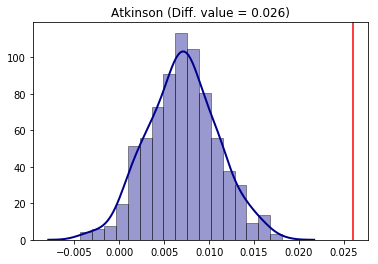

In [752]:
res.plot()